# Movie Recommendation System using Neural Collaborative Filtering
This notebook implements a recommendation system on the MovieLens 100k dataset using PyTorch.
We will use user and item embeddings, feed them through a neural network, and predict ratings.



In [18]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!ls "/content/drive/My Drive/recommendation system"


ml-100k


In [21]:
import os
os.chdir("/content/drive/My Drive/recommendation system")


In [22]:
data_path = 'ml-100k/'
print(os.listdir(data_path))


['allbut.pl', 'u2.test', 'mku.sh', 'u1.test', 'u.data', 'u.occupation', 'u.item', 'README', 'u.user', 'u3.test', 'u.info', 'u.genre', 'ua.test', 'u4.test', 'ub.test', 'u5.test', 'u4.base', 'u5.base', 'u3.base', 'u2.base', 'u1.base', 'ub.base', 'ua.base']


In [45]:
## Step 1: Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm  #
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [46]:
# Step 2: Set dataset path and basic information
data_path = 'ml-100k/'  # Folder containing u1.base, u1.test, etc.

id_val = 1
num_users = 943
num_items = 1682

# Load training and validation data
train_dataframe = pd.read_csv(f'{data_path}u{id_val}.base', sep='\t', header=None)
train_dataframe.columns = ['user_id','item_id','rating','ts']
train_dataframe['user_id'] -= 1
train_dataframe['item_id'] -= 1

valid_df = pd.read_csv(f'{data_path}u{id_val}.test', sep='\t', header=None)
valid_df.columns = ['user_id','item_id','rating','ts']
valid_df['user_id'] -= 1
valid_df['item_id'] -= 1

print("Train shape:", train_dataframe.shape)
print("Validation shape:", valid_df.shape)


Train shape: (80000, 4)
Validation shape: (20000, 4)


In [47]:
# Step 3: Check unique users and items
train_usrs = train_dataframe.user_id.unique()
vald_usrs = valid_df.user_id.unique()
train_itms = train_dataframe.item_id.unique()
vald_itms = valid_df.item_id.unique()

print("Unique users in train:", len(train_usrs))
print("Unique users in valid:", len(vald_usrs))
print("Unique items in train:", len(train_itms))
print("Unique items in valid:", len(vald_itms))


Unique users in train: 943
Unique users in valid: 459
Unique items in train: 1650
Unique items in valid: 1410


In [48]:
# Step 4: Define PyTorch Dataset class (CPU tensors)
# Step 5: Define PyTorch Dataset class
class CollabDataset(Dataset):
    def __init__(self, df, user_col=0, item_col=1, rating_col=2):
        self.df = df
        # CPU tensors first
        self.user_tensor = torch.tensor(self.df.iloc[:, user_col], dtype=torch.long)
        self.item_tensor = torch.tensor(self.df.iloc[:, item_col], dtype=torch.long)
        self.target_tensor = torch.tensor(self.df.iloc[:, rating_col], dtype=torch.float32)

    def __getitem__(self, index):
        return self.user_tensor[index], self.item_tensor[index], self.target_tensor[index]

    def __len__(self):
        return self.user_tensor.shape[0]

# Batch size
batch_size = 2000

# Create datasets and dataloaders
train_dataset = CollabDataset(train_dataframe)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

valid_dataset = CollabDataset(valid_df)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


Training the recommendation model

In [49]:
# Step 5: Define the neural network
class ConcatNet(nn.Module):
    def __init__(self, config):
        super(ConcatNet, self).__init__()
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.emb_size = config['emb_size']
        self.emb_dropout = config['emb_dropout']
        self.fc_layer_sizes = config['fc_layer_sizes']
        self.dropout = config['dropout']
        self.out_range = config['out_range']

        # Embeddings
        self.emb_user = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_dropout)
        )
        self.emb_item = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_dropout)
        )

        # Fully connected layers
        fc_layers_list = []
        for ni, nf, p in zip(self.fc_layer_sizes[:-1], self.fc_layer_sizes[1:], self.dropout):
            fc_layers_list.append(nn.Linear(ni, nf))
            fc_layers_list.append(nn.ReLU(inplace=True))
            fc_layers_list.append(nn.BatchNorm1d(nf))
            fc_layers_list.append(nn.Dropout(p=p))
        self.fc_layers = nn.Sequential(*fc_layers_list)

        # Output layer
        self.head = nn.Linear(self.fc_layer_sizes[-1], 1)

    def forward(self, user_idx, item_idx):
        user_emb = self.emb_user(user_idx.to(device))
        item_emb = self.emb_item(item_idx.to(device))
        x = torch.cat([user_emb, item_emb], dim=1)
        x = self.fc_layers(x)
        x = torch.sigmoid(self.head(x))
        x = x * (self.out_range[1] - self.out_range[0]) + self.out_range[0]
        return x


In [51]:
# Step 6: Config and model initialization
config = {
    'num_users': 943,
    'num_items': 1682,
    'emb_size': 50,
    'emb_dropout': 0.05,
    'fc_layer_sizes': [100, 512, 256],
    'dropout': [0.7, 0.35],
    'out_range': [0.8, 5.2]
}

model = ConcatNet(config).to(device)


In [53]:
# Training setup

# Step 7: Training setup
learning_rate = 1e-2
weight_decay = 5e-1
num_epoch = 100
reduce_learning_rate = 1
early_stopping = 5

criterion = nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=reduce_learning_rate, min_lr=learning_rate/10)

learning_rates = []
train_losses = []
valid_losses = []
best_loss = np.inf
best_weights = None
no_improvements = 0


In [54]:
# Step 8: Training loop
for e in tqdm(range(num_epoch)):
    model.train()
    train_loss = 0
    for u, i, r in train_dataloader:
        u, i, r = u.to(device), i.to(device), r.to(device)
        r = r[:, None]

        r_pred = model(u, i)
        loss = criterion(r_pred, r)

        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss += loss.detach().item()

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for u, i, r in valid_dataloader:
            u, i, r = u.to(device), i.to(device), r.to(device)
            r = r[:, None]
            r_pred = model(u, i)
            loss = criterion(r_pred, r)
            valid_loss += loss.detach().item()
    valid_loss /= len(valid_dataset)
    valid_losses.append(valid_loss)

    current_lr = optim.param_groups[0]['lr']
    learning_rates.append(current_lr)

    print(f'Epoch {e}: Train loss={train_loss:.4f}, Valid loss={valid_loss:.4f}, LR={current_lr}')

    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1

    if no_improvements >= early_stopping:
        print(f'Early stopping at epoch {e}')
        break

    scheduler.step(valid_loss)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: Train loss=1.3677, Valid loss=1.1571, LR=0.01
Epoch 1: Train loss=1.0793, Valid loss=1.0494, LR=0.01
Epoch 2: Train loss=0.9763, Valid loss=0.9737, LR=0.01
Epoch 3: Train loss=0.9224, Valid loss=0.9410, LR=0.01
Epoch 4: Train loss=0.9020, Valid loss=0.9326, LR=0.01
Epoch 5: Train loss=0.8856, Valid loss=0.9198, LR=0.01
Epoch 6: Train loss=0.8741, Valid loss=0.9152, LR=0.01
Epoch 7: Train loss=0.8662, Valid loss=0.9081, LR=0.01
Epoch 8: Train loss=0.8579, Valid loss=0.9062, LR=0.01
Epoch 9: Train loss=0.8534, Valid loss=0.9069, LR=0.01
Epoch 10: Train loss=0.8428, Valid loss=0.8887, LR=0.01
Epoch 11: Train loss=0.8310, Valid loss=0.8826, LR=0.01
Epoch 12: Train loss=0.8253, Valid loss=0.8798, LR=0.01
Epoch 13: Train loss=0.8160, Valid loss=0.8783, LR=0.01
Epoch 14: Train loss=0.8141, Valid loss=0.8779, LR=0.01
Epoch 15: Train loss=0.8137, Valid loss=0.8807, LR=0.01
Epoch 16: Train loss=0.8053, Valid loss=0.8718, LR=0.01
Epoch 17: Train loss=0.8028, Valid loss=0.8738, LR=0.01
Ep

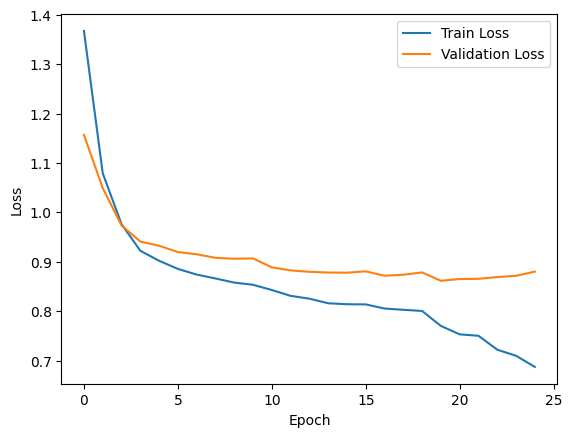

In [55]:
# Step 10: Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [64]:
torch.save(best_weights, 'concatnet_best_weights.pth')
print("Weights saved!")


Weights saved!


In [66]:
#  Load saved model weights
model = ConcatNet(config).to(device)
model.load_state_dict(torch.load('concatnet_best_weights.pth'))
model.eval()
print("Model loaded! Ready for predictions.\n")



Model loaded! Ready for predictions.



In [57]:
# Load MovieLens movie metadata
movies_df = pd.read_csv(f'{data_path}u.item', sep='|', encoding='latin-1', header=None, usecols=[0,1], names=['movie_id','title'])
movies_df['movie_id'] -= 1  # 0-based indexing

def get_movie_titles(movie_ids):
    return movies_df[movies_df['movie_id'].isin(movie_ids)]['title'].tolist()


In [67]:
#  Recommendation function (all movies)
def recommend_movies(user_id, model, num_items=1682, top_n=5):
    model.eval()
    user_tensor = torch.tensor([user_id]*num_items).to(device)
    item_tensor = torch.arange(num_items).to(device)

    with torch.no_grad():
        scores = model(user_tensor, item_tensor).squeeze()

    top_scores, top_movie_ids = torch.topk(scores, top_n)
    return top_movie_ids.cpu().tolist(), top_scores.cpu().tolist()

In [68]:
while True:
    user_input = input("Enter MovieLens user ID (1-943) or 'q' to quit: ")
    if user_input.lower() == 'q':
        print("Exiting...")
        break
    try:
        user_id = int(user_input) - 1
        if user_id < 0 or user_id >= num_users:
            raise ValueError
    except:
        print("Invalid input. Please enter a number between 1 and 943.")
        continue

    top_movies, scores = recommend_movies(user_id, model, num_items=num_items, top_n=5)
    titles = get_movie_titles(top_movies)

    print(f"\nTop 5 recommendations for User {user_id+1}:")
    for t, s in zip(titles, scores):
        print(f"{t} - Predicted rating: {s:.2f}")
    print("\n" + "-"*40 + "\n")


Enter MovieLens user ID (1-943) or 'q' to quit: 20

Top 5 recommendations for User 20:
Star Wars (1977) - Predicted rating: 3.91
Terminator 2: Judgment Day (1991) - Predicted rating: 3.88
Wrong Trousers, The (1993) - Predicted rating: 3.87
Raiders of the Lost Ark (1981) - Predicted rating: 3.86
Titanic (1997) - Predicted rating: 3.85

----------------------------------------

Enter MovieLens user ID (1-943) or 'q' to quit: 4

Top 5 recommendations for User 4:
One Flew Over the Cuckoo's Nest (1975) - Predicted rating: 4.85
Close Shave, A (1995) - Predicted rating: 4.82
Casablanca (1942) - Predicted rating: 4.81
Third Man, The (1949) - Predicted rating: 4.81
Chinatown (1974) - Predicted rating: 4.80

----------------------------------------

Enter MovieLens user ID (1-943) or 'q' to quit: 4

Top 5 recommendations for User 4:
One Flew Over the Cuckoo's Nest (1975) - Predicted rating: 4.85
Close Shave, A (1995) - Predicted rating: 4.82
Casablanca (1942) - Predicted rating: 4.81
Third Man, 